# Big Cities Health Data

## Load Modules

In [1]:
# Data manipulation
import pandas as pd
pd.options.display.max_columns = 60
import numpy as np
from IPython.display import display

# Visualizations
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid': False})

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Load and Sample Data

The following creates a small sample file that can be opened easily in Excel.

In [2]:
import unicodecsv

with open('data/bchi.csv', 'rb') as fin:
    freader = unicodecsv.reader(fin, delimiter=',')
    with open('data/bchi_sample.csv', 'wb') as fout:
        fwriter = unicodecsv.writer(fout, delimiter=',')
        count = 0
        for row in freader:            
            fwriter.writerow(row)
            count += 1
            if count==250:
                break

In [3]:
health = pd.read_csv('data/bchi.csv')
health_df = pd.DataFrame(health)

In [4]:
location_df = health_df.copy()
location_df.loc[:,'City'] = location_df['Place'].str.split(', ').str.get(0)
location_df.loc[:,'State'] = location_df['Place']
location_df.loc[location_df['State']!='U.S. Total','State'] = location_df['Place'].str.split(', ').str.get(1)
location_df.to_csv('data/bhmi_locations.csv')

## Data Structure

In [5]:
health_df.shape

(18329, 17)

In [6]:
health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18329 entries, 0 to 18328
Data columns (total 17 columns):
Indicator Category                  18329 non-null object
Indicator                           18329 non-null object
Shortened Indicator Name            18329 non-null object
Shortened Indicator Name (Graph)    1643 non-null object
Year                                18329 non-null int64
Sex                                 18329 non-null object
Race/Ethnicity                      18329 non-null object
Value                               18329 non-null object
Place                               18329 non-null object
BCHC Requested Methodology          18329 non-null object
Source                              15907 non-null object
Methods                             5084 non-null object
Notes                               5054 non-null object
90% Confidence Level - Low          2359 non-null object
90% Confidence Level - High         2359 non-null object
95% Confidence Level - Low 

In [7]:
health_df.describe(include=['O'])

Indicator Category                        Indicator  \
count               18329                            18329   
unique                 11                               53   
top       Chronic Disease  Percent of Population Uninsured   
freq                 3150                              706   

       Shortened Indicator Name             Shortened Indicator Name (Graph)  \
count                     18329                                         1643   
unique                       53                                            6   
top        Population Uninsured  Rate of Lab Confirmed Salmonella Infections   
freq                        706                                          503   

          Sex Race/Ethnicity  Value       Place  \
count   18329          18329  18329       18329   
unique      3             11   2915          27   
top      Both            All    0.0  U.S. Total   
freq    12737           8107    253        1288   

                               BCHC Requested Methodology  \
count                                               18329   
unique                                                322   
top     All cancer mortality rate per 100,000 populati...   
freq                                                  674   

                                                   Source  \
count                                               15907   
unique                                                640   
top     DP05 - Demographic and Housing Estimates: ACS ...   
freq                                                  780   

                                                  Methods  \
count                                                5084   
unique                                                254   
top     Rates per 100,000 calculated using the Minneap...   
freq                                                  566   

                                                    Notes  \
count                                                5054   
unique                                                211   
top     Deaths for which cause was listed as Òdeferred...   
freq                                                  342   

       90% Confidence Level - Low 90% Confidence Level - High  \
count                        2359                        2359   
unique                        583                         654   
top                           0.1                         0.3   
freq                           31                          28   

       95% Confidence Level - Low 95% Confidence Level - High  
count                        2264                        2264  
unique                        817                         948  
top                           4.7                        13.4  
freq                           19                          13

Hmm, it looks like some of the floats are being cast as objects. I'll have to clean those up in the next section.

In [8]:
health_df.describe(include=['int64'])

Year
count  18329.000000
mean    2012.393529
std        1.332788
min     2010.000000
25%     2011.000000
50%     2012.000000
75%     2013.000000
max     2016.000000

In [9]:
health_df.head()

Indicator Category                          Indicator  \
0  Behavioral Health/Substance Abuse  Percent of Adults Who Binge Drank   
1  Behavioral Health/Substance Abuse  Percent of Adults Who Binge Drank   
2  Behavioral Health/Substance Abuse  Percent of Adults Who Binge Drank   
3  Behavioral Health/Substance Abuse  Percent of Adults Who Binge Drank   
4  Behavioral Health/Substance Abuse  Percent of Adults Who Binge Drank   

  Shortened Indicator Name Shortened Indicator Name (Graph)  Year     Sex  \
0     Adult Binge Drinking                              NaN  2010    Both   
1     Adult Binge Drinking                              NaN  2010    Both   
2     Adult Binge Drinking                              NaN  2010    Both   
3     Adult Binge Drinking                              NaN  2010  Female   
4     Adult Binge Drinking                              NaN  2010    Male   

  Race/Ethnicity Value          Place  \
0            All  14.5  Baltimore, MD   
1          Black   9.5  Baltimore, MD   
2          White  21.1  Baltimore, MD   
3            All   9.7  Baltimore, MD   
4            All  20.3  Baltimore, MD   

                          BCHC Requested Methodology     Source  \
0   BRFSS (or similar) How many times during the ...  CDC BRFSS   
1   BRFSS (or similar) How many times during the ...  CDC BRFSS   
2   BRFSS (or similar) How many times during the ...  CDC BRFSS   
3   BRFSS (or similar) How many times during the ...  CDC BRFSS   
4   BRFSS (or similar) How many times during the ...  CDC BRFSS   

                                             Methods  \
0  The three most recent years of available data ...   
1  The three most recent years of available data ...   
2  The three most recent years of available data ...   
3  The three most recent years of available data ...   
4  The three most recent years of available data ...   

                                               Notes  \
0  Due to changes in BRFSS sampling methodology, ...   
1  Due to changes in BRFSS sampling methodology, ...   
2  Due to changes in BRFSS sampling methodology, ...   
3  Due to changes in BRFSS sampling methodology, ...   
4  Due to changes in BRFSS sampling methodology, ...   

  90% Confidence Level - Low 90% Confidence Level - High  \
0                        NaN                         NaN   
1                        NaN                         NaN   
2                        NaN                         NaN   
3                        NaN                         NaN   
4                        NaN                         NaN   

  95% Confidence Level - Low 95% Confidence Level - High  
0                        NaN                         NaN  
1                        NaN                         NaN  
2                        NaN                         NaN  
3                        NaN                         NaN  
4                        NaN                         NaN

In [10]:
health_df.tail()

Indicator Category                        Indicator  \
18324  Maternal and Child Health  Percent of Mothers Under Age 20   
18325  Maternal and Child Health  Percent of Mothers Under Age 20   
18326  Maternal and Child Health  Percent of Mothers Under Age 20   
18327  Maternal and Child Health  Percent of Mothers Under Age 20   
18328  Maternal and Child Health  Percent of Mothers Under Age 20   

      Shortened Indicator Name Shortened Indicator Name (Graph)  Year     Sex  \
18324             Teen Mothers                              NaN  2012  Female   
18325             Teen Mothers                              NaN  2012  Female   
18326             Teen Mothers                              NaN  2012  Female   
18327             Teen Mothers                              NaN  2012  Female   
18328             Teen Mothers                              NaN  2012  Female   

      Race/Ethnicity Value           Place  \
18324            All   8.5  Washington, DC   
18325       Asian/PI   0.7  Washington, DC   
18326          Black  14.1  Washington, DC   
18327       Hispanic   8.0  Washington, DC   
18328          White   0.5  Washington, DC   

                              BCHC Requested Methodology Source Methods Notes  \
18324  Percentage of mothers giving birth under 20 ye...    NaN     NaN   NaN   
18325  Percentage of mothers giving birth under 20 ye...    NaN     NaN   NaN   
18326  Percentage of mothers giving birth under 20 ye...    NaN     NaN   NaN   
18327  Percentage of mothers giving birth under 20 ye...    NaN     NaN   NaN   
18328  Percentage of mothers giving birth under 20 ye...    NaN     NaN   NaN   

      90% Confidence Level - Low 90% Confidence Level - High  \
18324                        NaN                         NaN   
18325                        NaN                         NaN   
18326                        NaN                         NaN   
18327                        NaN                         NaN   
18328                        NaN                         NaN   

      95% Confidence Level - Low 95% Confidence Level - High  
18324                        NaN                         NaN  
18325                        NaN                         NaN  
18326                        NaN                         NaN  
18327                        NaN                         NaN  
18328                        NaN                         NaN

In [11]:
len(health_df[health_df.isnull().any(axis=1)])

18329

Looks like all 18,329 rows have at least one column with a missing value.

### Data Cleaning

#### Remove Extra Whitespace

In [12]:
object_cols = health_df.select_dtypes(include=['object']).columns

for object_col in object_cols:
    health_df[object_col] = health_df[object_col].str.rstrip()

#### Convert Year to Date Object

In [13]:
health_df.Year = pd.to_datetime(health_df.Year, format='%Y')

#### Convert Values to Floats

In [14]:
float_cols = [
    'Value', 
    '90% Confidence Level - Low', 
    '90% Confidence Level - High',
    '95% Confidence Level - Low',
    '95% Confidence Level - High'
]

In [15]:
for float_col in float_cols:    
    health_df[float_col] = health_df[float_col].str.replace(',', '')
    health_df[float_col] = health_df[float_col].str.replace('\xc2\xa0', '')
    health_df[float_col] = pd.to_numeric(health_df[float_col])

In [16]:
health_df.describe()

Value  90% Confidence Level - Low  90% Confidence Level - High  \
count  1.832900e+04                2.359000e+03                 2.359000e+03   
mean   5.881867e+04                2.144293e+04                 2.146457e+04   
std    4.049222e+06                2.095064e+05                 2.096142e+05   
min    0.000000e+00               -9.000000e-01                 2.000000e-01   
25%    7.000000e+00                6.800000e+00                 9.500000e+00   
50%    1.590000e+01                1.190000e+01                 1.620000e+01   
75%    4.130000e+01                2.710000e+01                 3.355000e+01   
max    3.188571e+08                3.928733e+06                 3.928921e+06   

       95% Confidence Level - Low  95% Confidence Level - High  
count                 2264.000000                  2264.000000  
mean                    58.185689                    76.677871  
std                    141.721620                   176.471644  
min                     -0.100000                     0.100000  
25%                      6.200000                    11.975000  
50%                     14.950000                    24.750000  
75%                     37.900000                    54.525000  
max                   1558.400000                  1996.500000

Minor annoyance

In [17]:
health_df.rename(columns ={'Place': 'Location'}, inplace=True)

### Missing Data

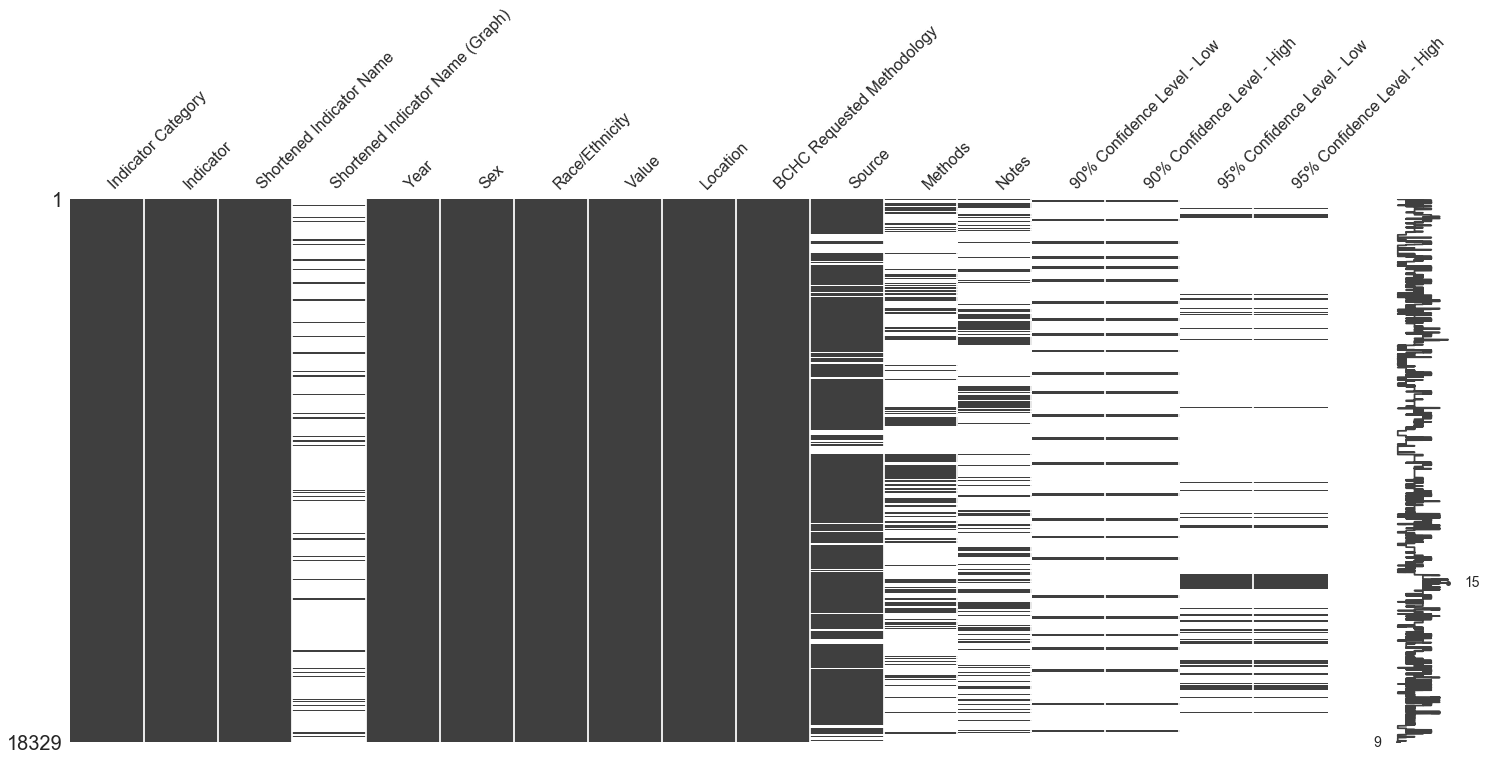

In [17]:
msno.matrix(health_df)

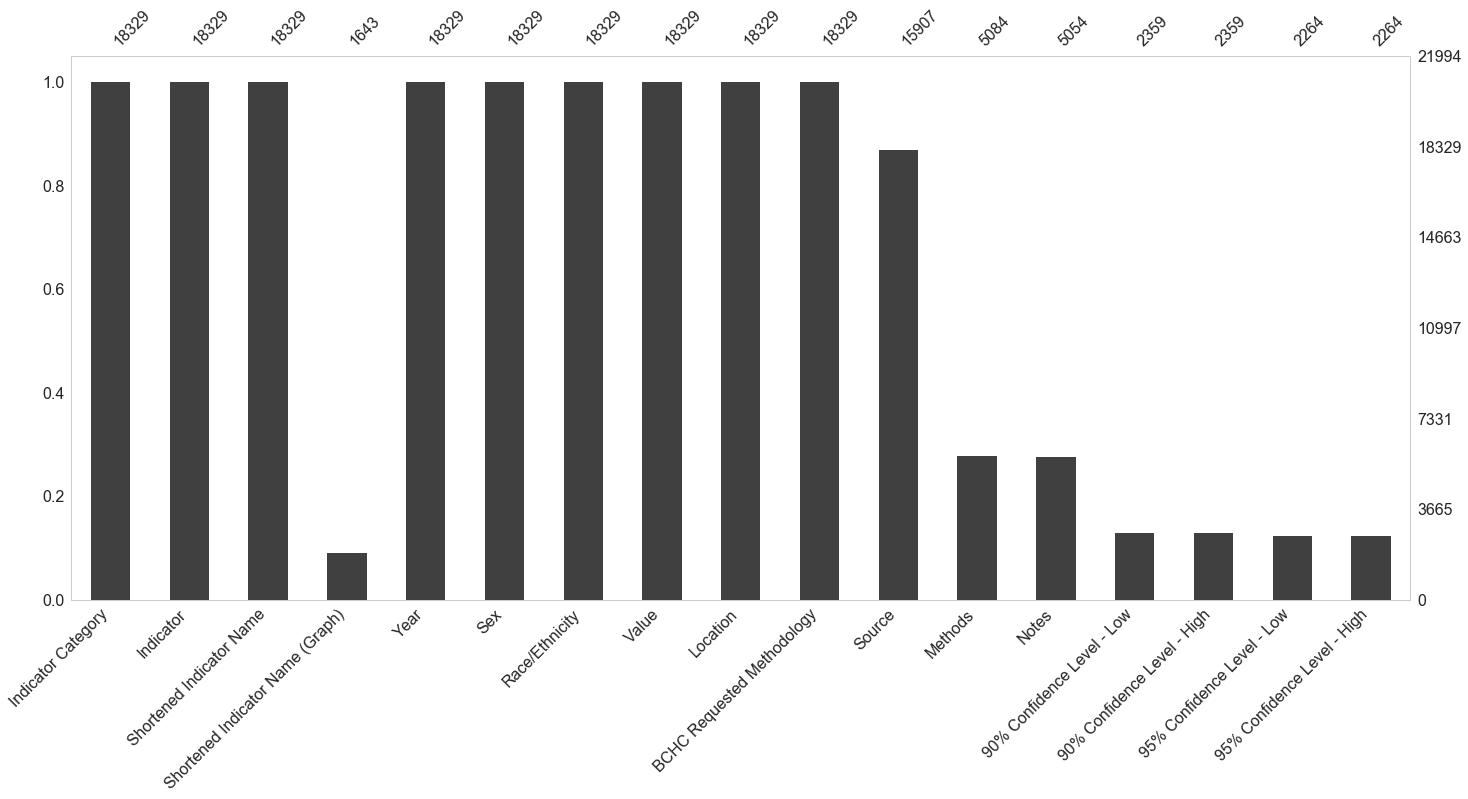

In [18]:
msno.bar(health_df)

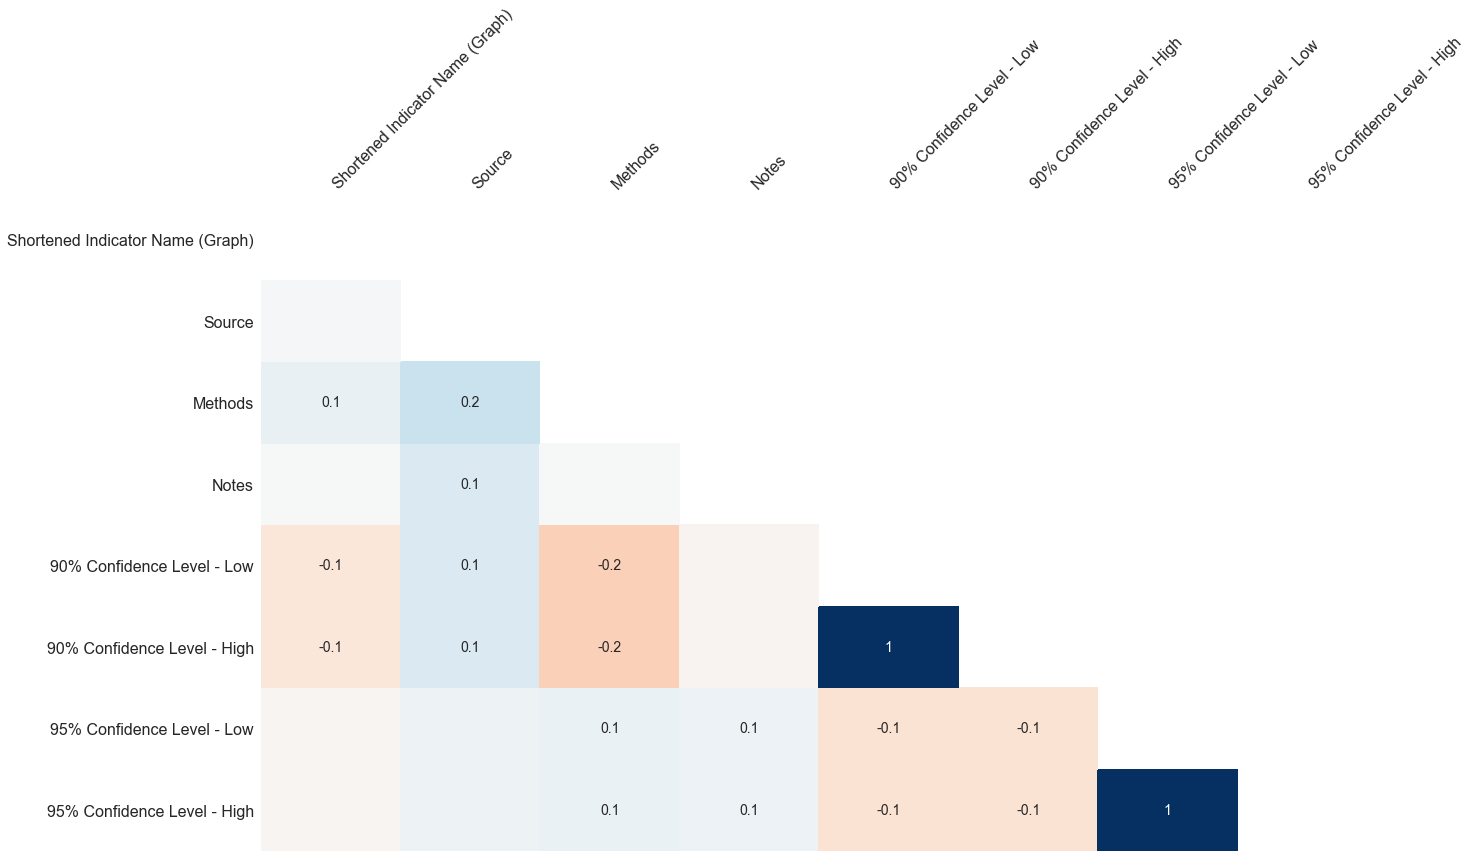

In [19]:
msno.heatmap(health_df)

### Indicator Counts

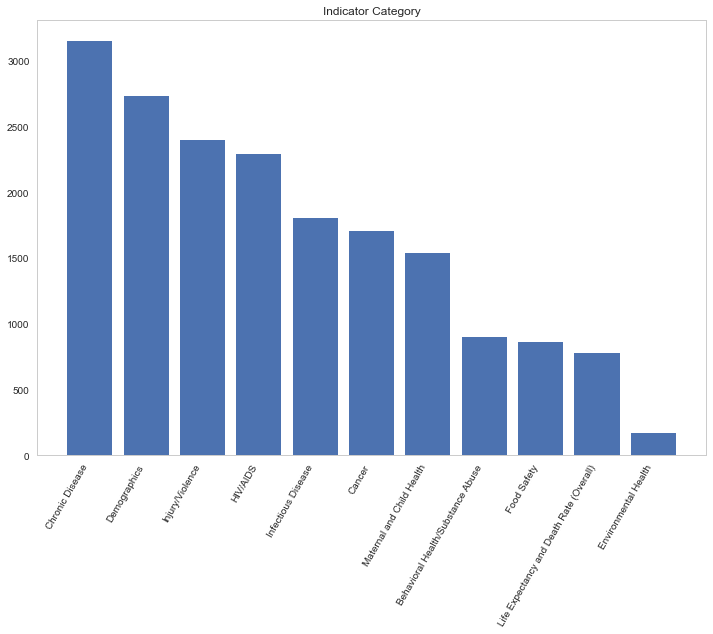

In [29]:
indicator_categories = health_df['Indicator Category'].value_counts()
x = indicator_categories.index
y = indicator_categories.values
plt.figure(figsize=(12,8))
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x, rotation=60, ha='right')
plt.title('Indicator Category')
plt.show()

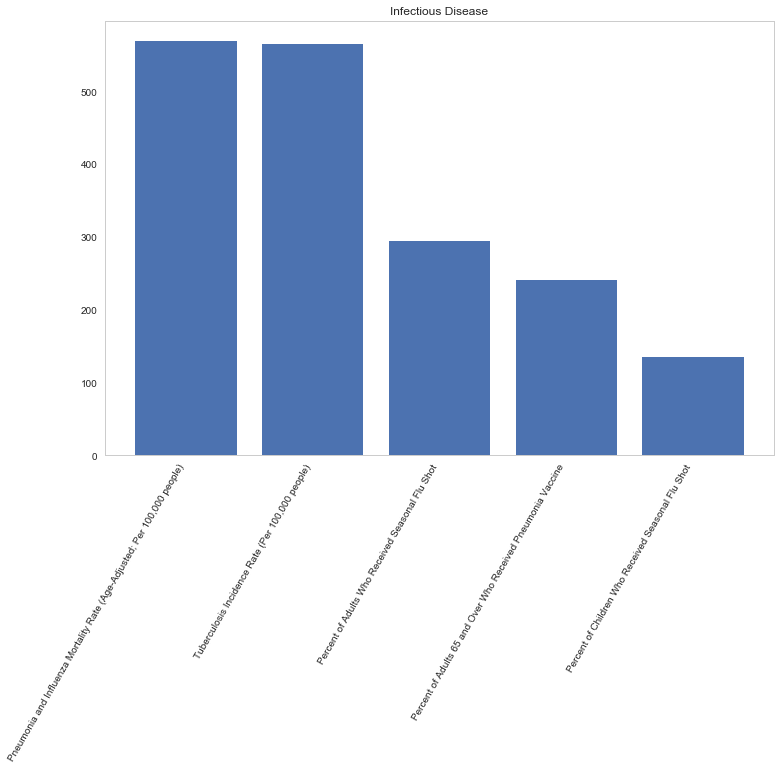

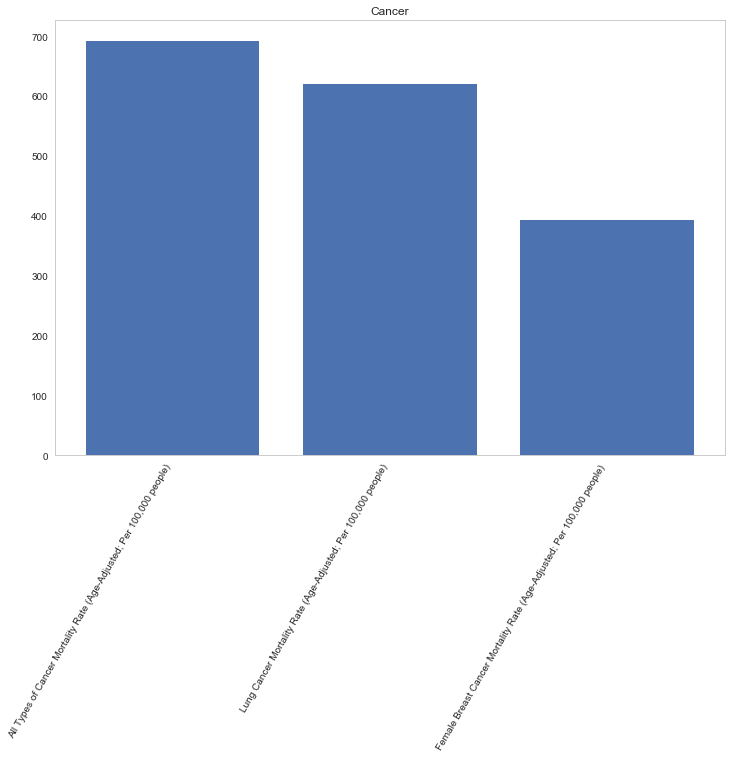

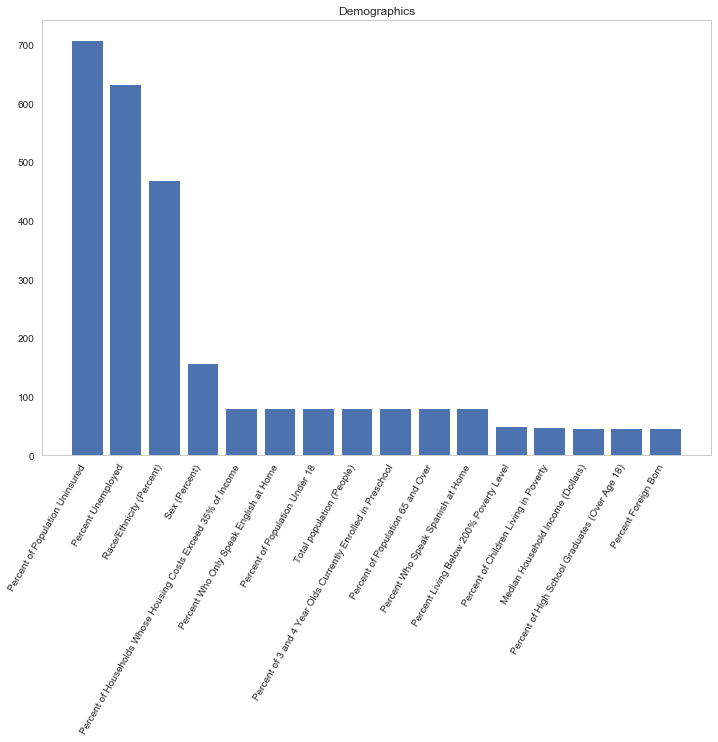

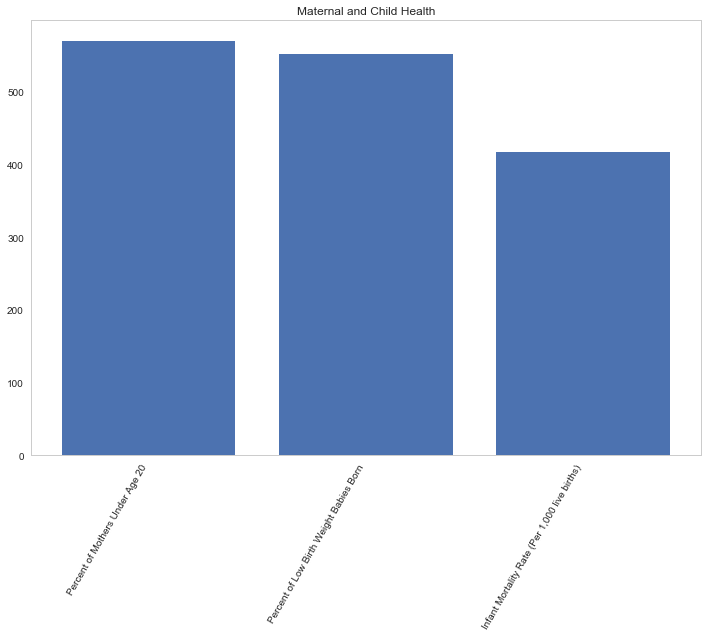

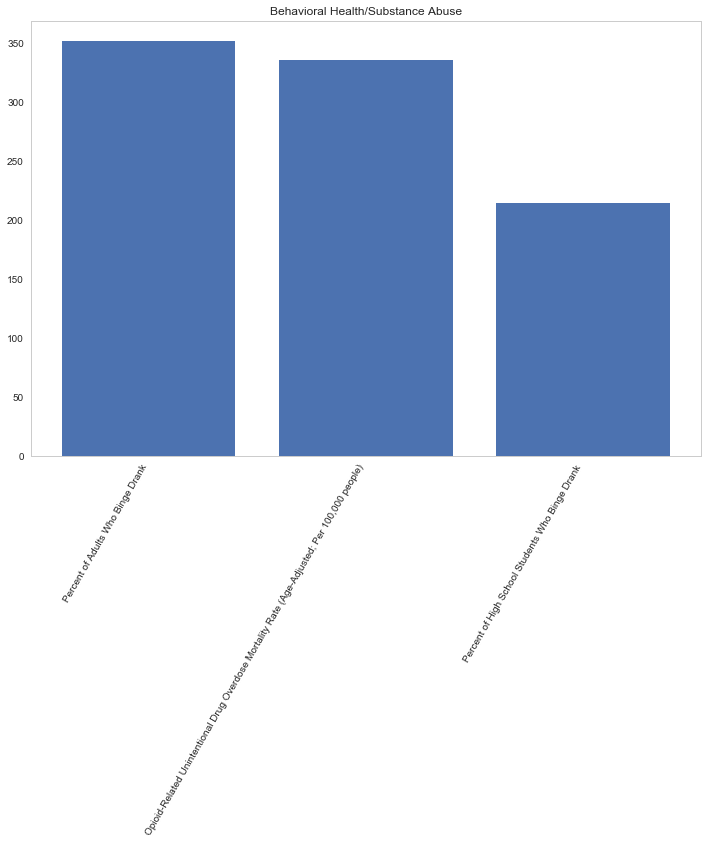

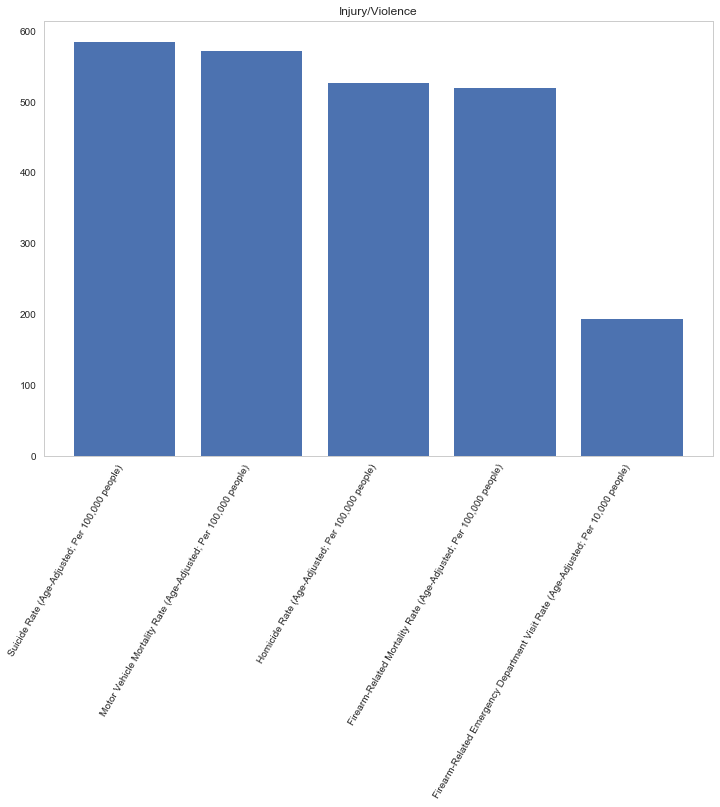

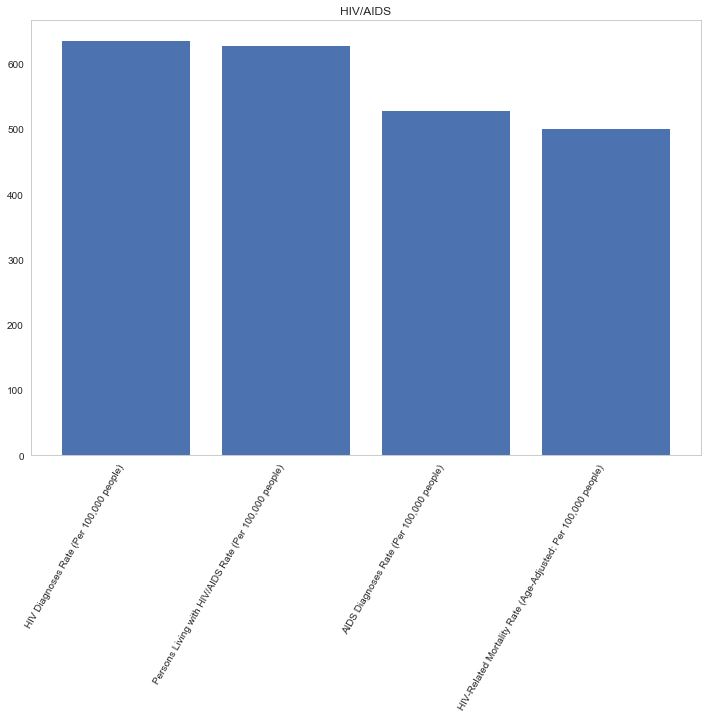

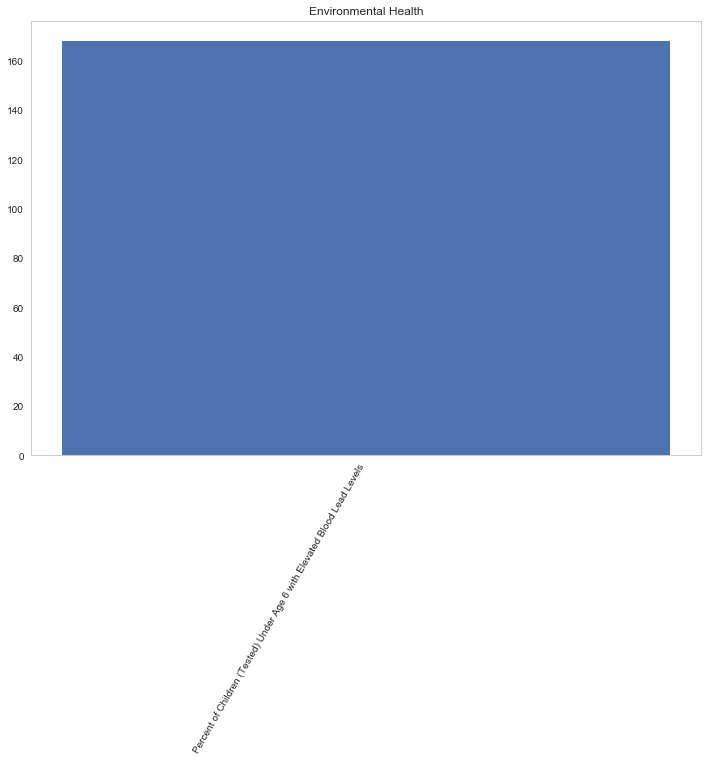

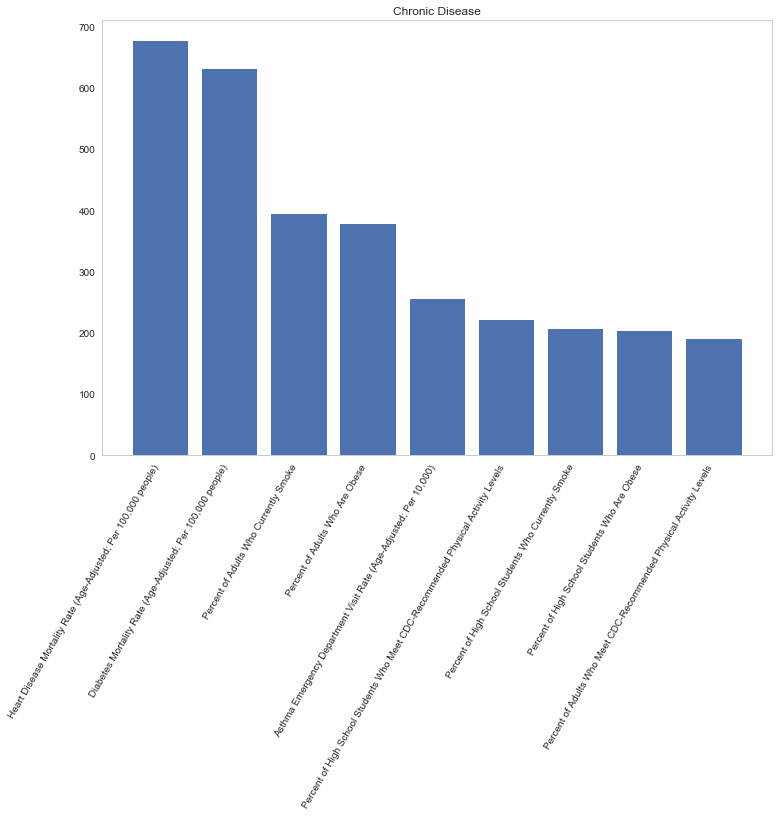

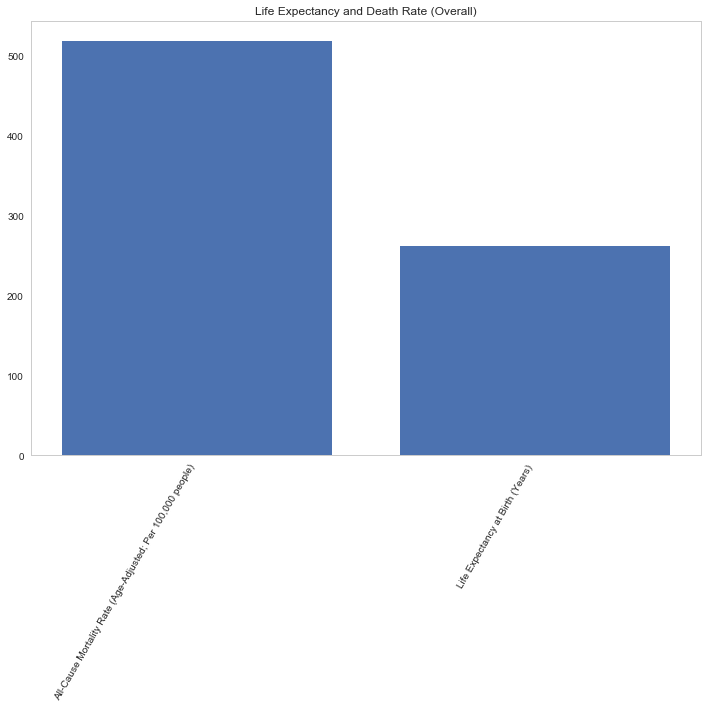

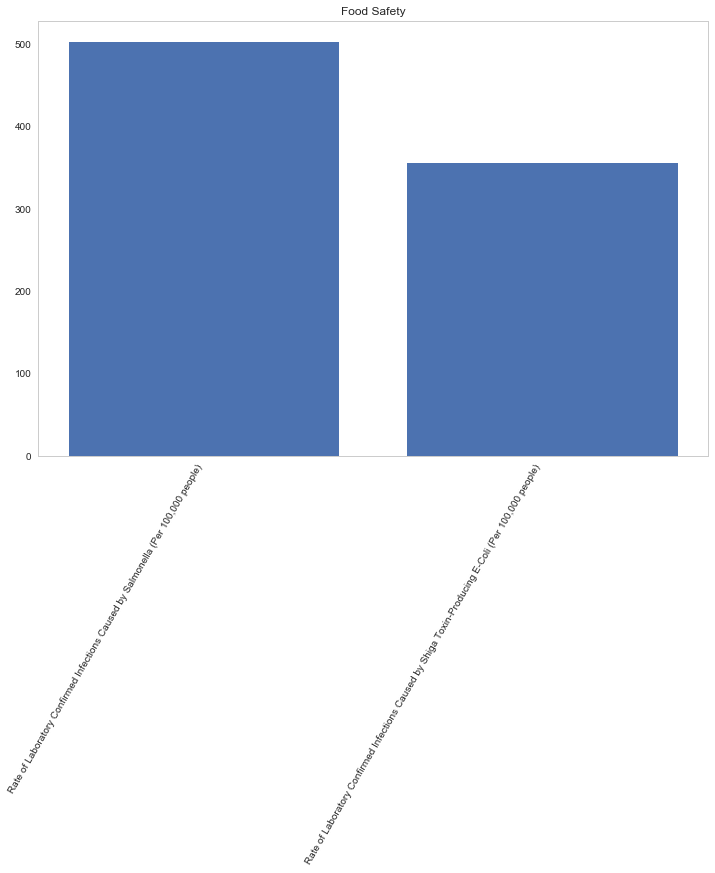

In [30]:
categories = set(health_df['Indicator Category'])

for category in categories:
    category_counts = health_df[health_df['Indicator Category'] == category]['Indicator'].value_counts()
    x = category_counts.index
    y = category_counts.values
    plt.figure(figsize=(12,8))
    plt.bar(range(len(x)), y)
    plt.xticks(range(len(x)), x, rotation=60, ha='right')
    plt.title(category)
    plt.show()
    

### Reshaping the Data

Reshape the data. Need to organize by:
- Location
- Year
- Gender
- Race/Ethnicity

Designate the columns:
- Year
- Sex
- Race/Ethnicity
- Value
- Place
- List of the unique Indicators



In [18]:
health_reshaped = health_df.pivot_table(
    index=['Location', 'Year', 'Sex', 'Race/Ethnicity'],
    columns='Indicator',
    values='Value'
)
health_reshaped.reset_index(inplace=True)
health_reshaped.columns.name = None
health_reshaped.head()

Location       Year   Sex Race/Ethnicity  \
0  Baltimore, MD 2010-01-01  Both            All   
1  Baltimore, MD 2010-01-01  Both       Asian/PI   
2  Baltimore, MD 2010-01-01  Both          Black   
3  Baltimore, MD 2010-01-01  Both       Hispanic   
4  Baltimore, MD 2010-01-01  Both          White   

   AIDS Diagnoses Rate (Per 100,000 people)  \
0                                      57.9   
1                                       NaN   
2                                      78.5   
3                                      44.4   
4                                      15.8   

   All Types of Cancer Mortality Rate (Age-Adjusted; Per 100,000 people)  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   All-Cause Mortality Rate (Age-Adjusted; Per 100,000 people)  \
0                                                NaN             
1                                                NaN             
2                                                NaN             
3                                                NaN             
4                                                NaN             

   Asthma Emergency Department Visit Rate (Age-Adjusted; Per 10,000)  \
0                                                NaN                   
1                                                NaN                   
2                                                NaN                   
3                                                NaN                   
4                                                NaN                   

   Diabetes Mortality Rate (Age-Adjusted; Per 100,000 people)  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

   Female Breast Cancer Mortality Rate (Age-Adjusted; Per 100,000 people)  \
0                                                NaN                        
1                                                NaN                        
2                                                NaN                        
3                                                NaN                        
4                                                NaN                        

   Firearm-Related Emergency Department Visit Rate (Age-Adjusted; Per 10,000 people)  \
0                                                NaN                                   
1                                                NaN                                   
2                                                NaN                                   
3                                                NaN                                   
4                                                NaN                                   

   Firearm-Related Mortality Rate (Age-Adjusted; Per 100,000 people)  \
0                                                NaN                   
1                                                NaN                   
2                                                NaN                   
3                                                NaN                   
4                                                NaN                   

   HIV Diagnoses Rate (Per 100,000 people)  \
0                                     77.6   
1                                      NaN   
2                                    108.3   
3                                     59.1   
4                                     19.0   

   HIV-Related Mortality Rate (A

In [19]:
health_reshaped.to_csv('data/bhmi_reshaped.csv')

## Visualizations

1. Correlation matrix
1. Bar plots
2. Histograms
3. Violin plots
5. Wordcloud
6. Scatterplots colored by label
 1. Add scatterplot with histograms on each axis
7. Line plot for time data
8. Choropleth for location data
9. 2d graph from Uber data
10. Graph / tree
11. New graph from kaggle

Get indicator name and category value counts.

### Reshaped Missing Data

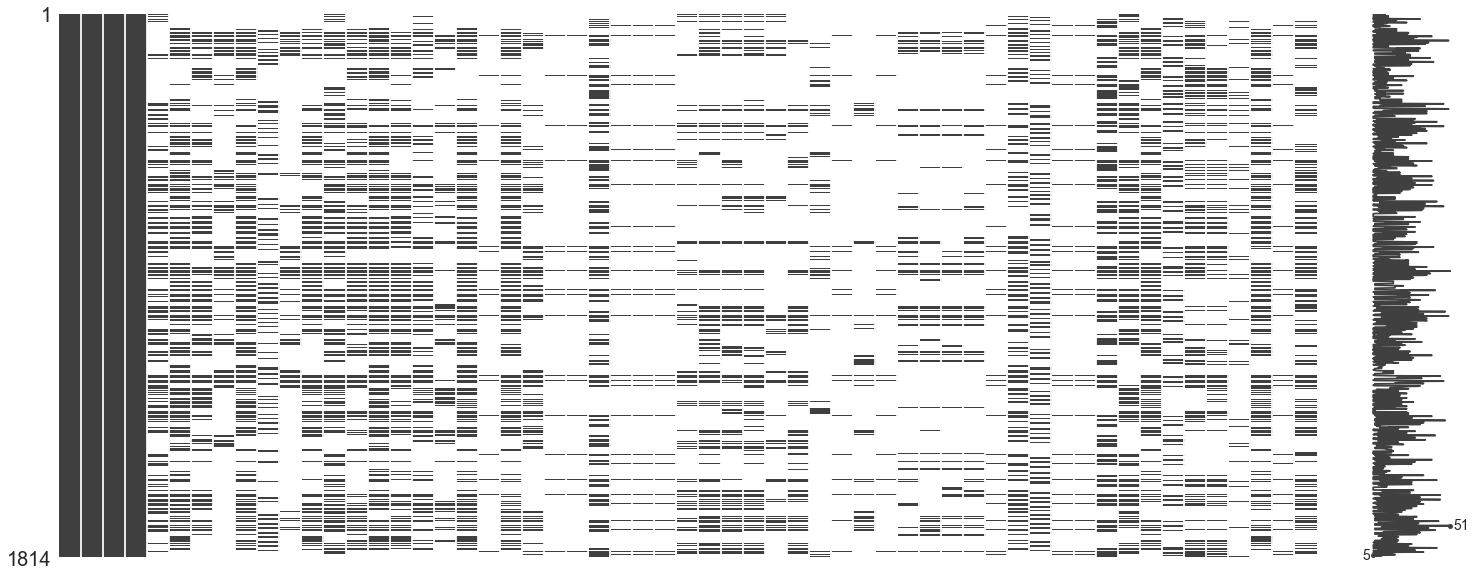

In [20]:
msno.matrix(health_reshaped)

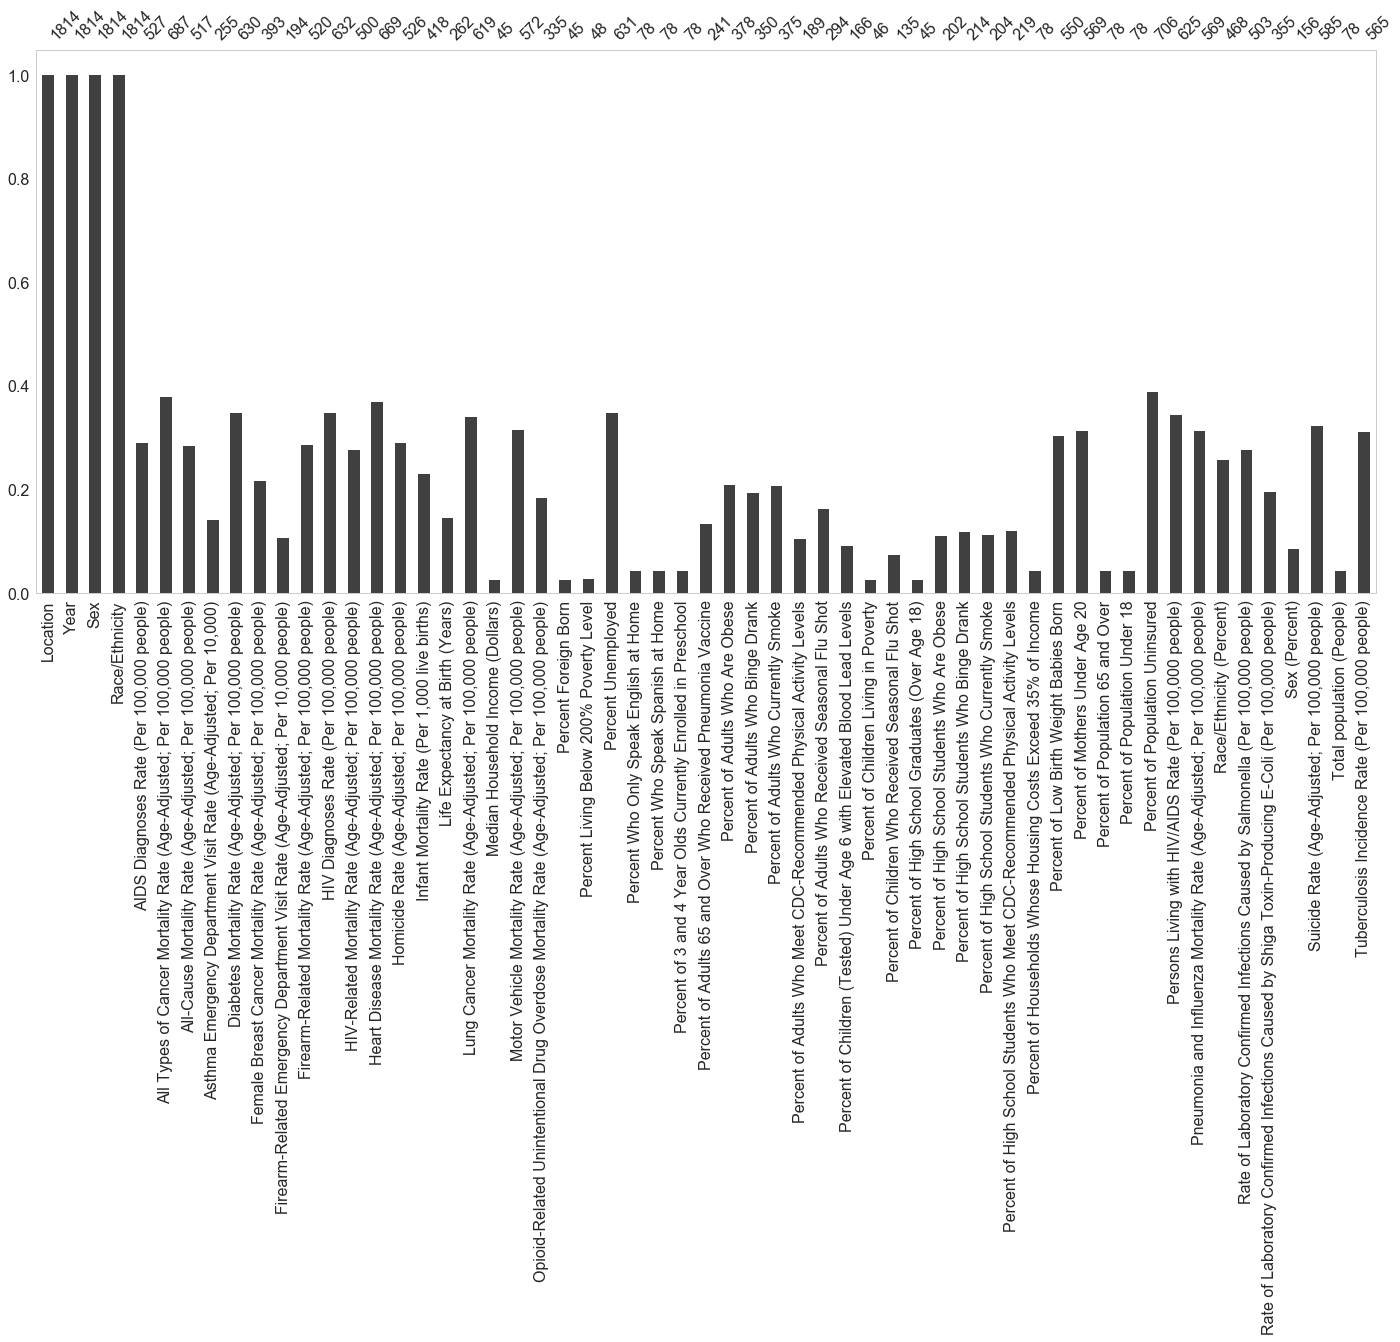

In [21]:
msno.bar(health_reshaped)

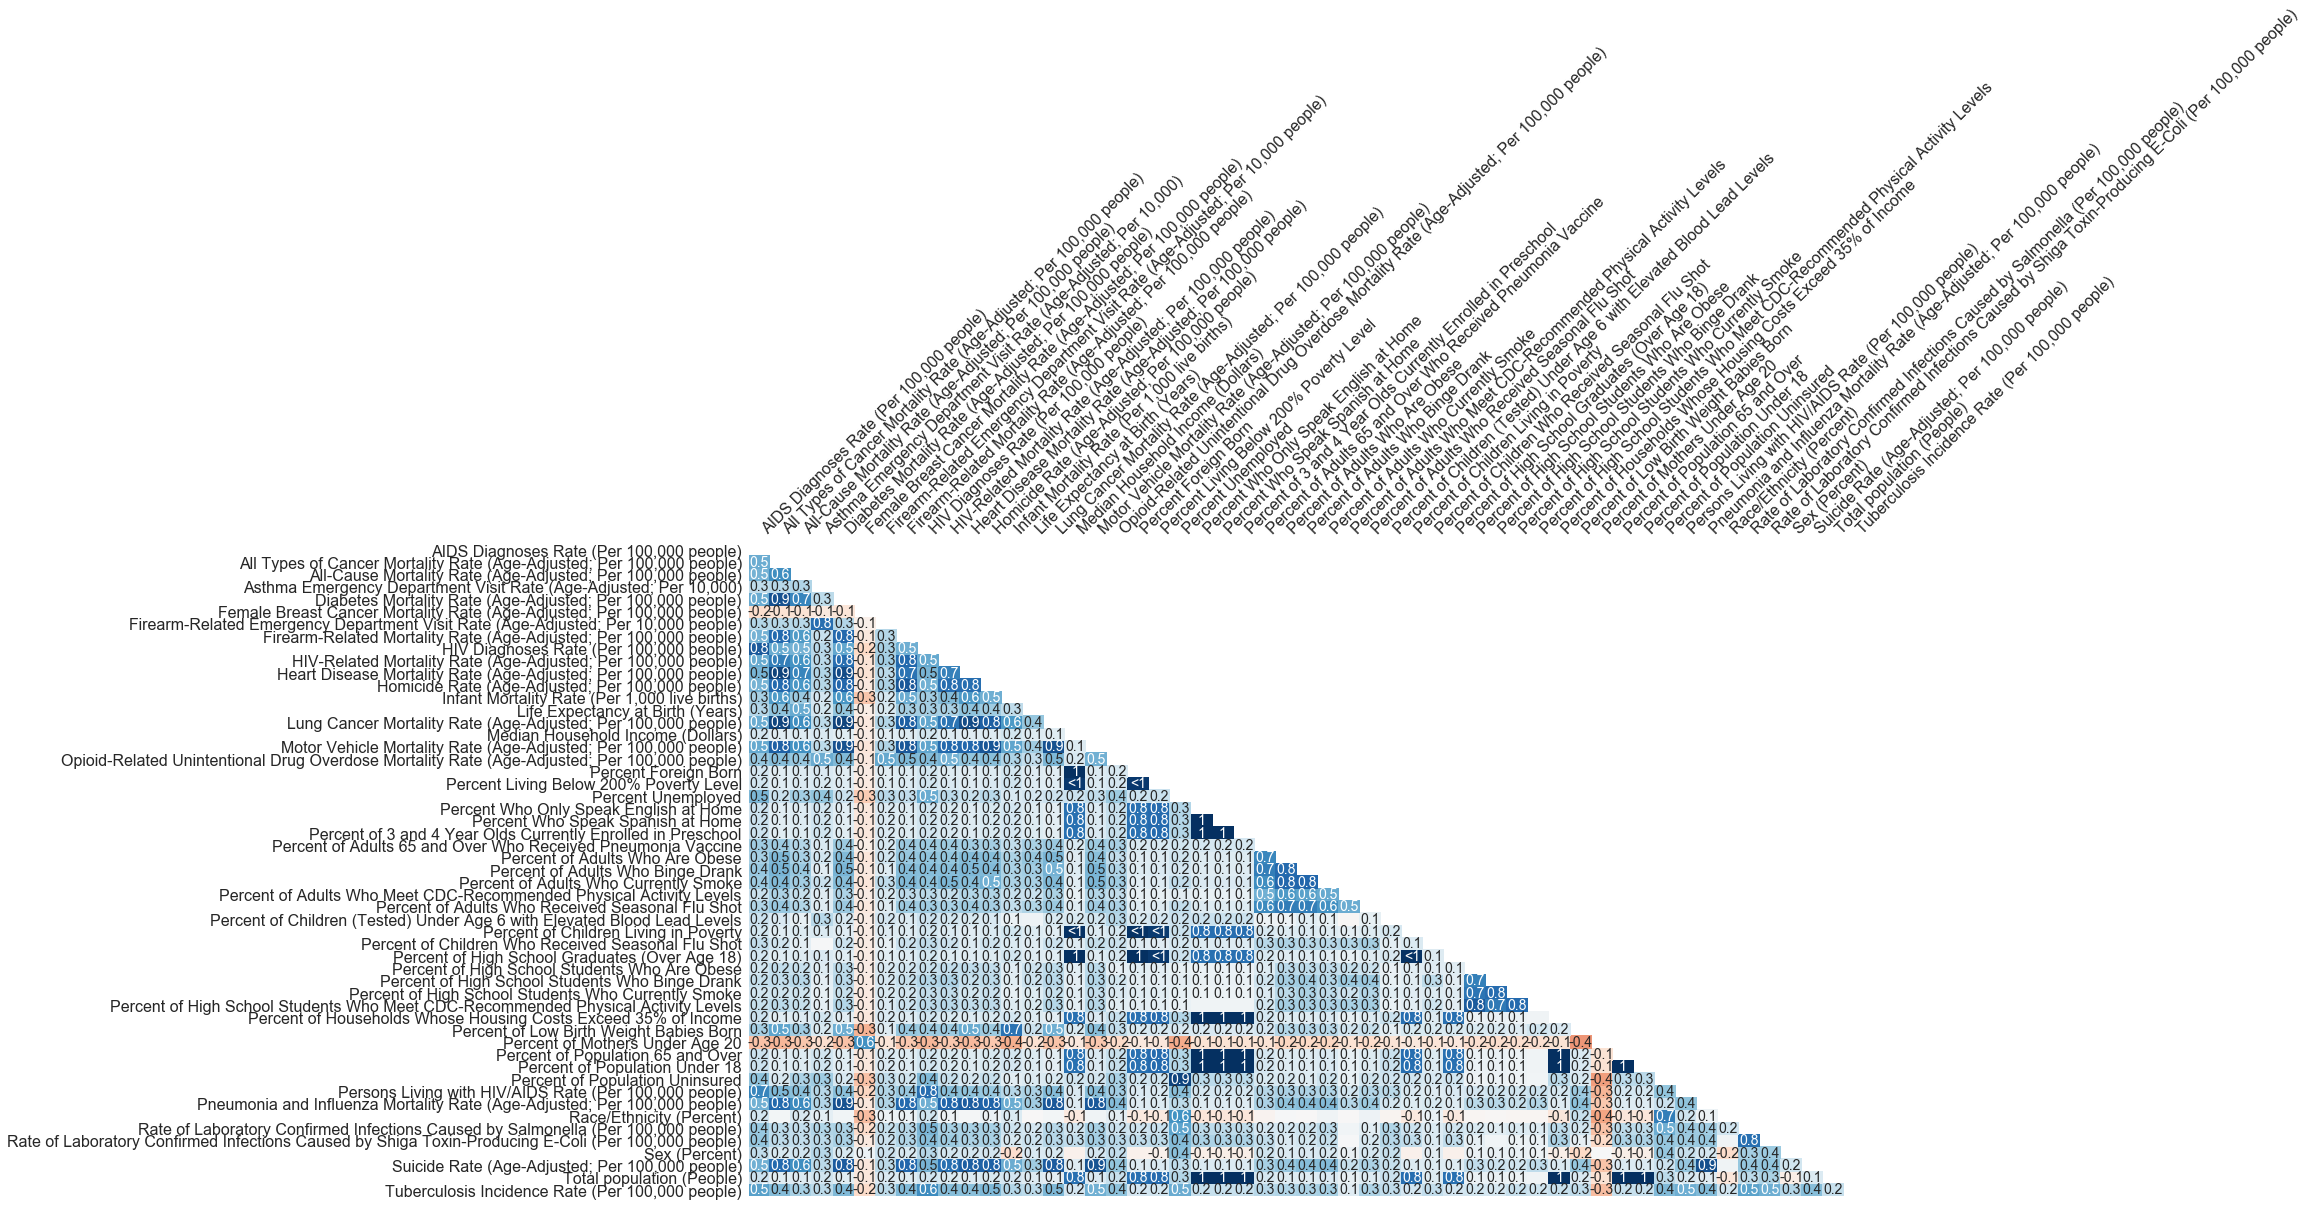

In [34]:
msno.heatmap(health_reshaped)

In [22]:
health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18329 entries, 0 to 18328
Data columns (total 17 columns):
Indicator Category                  18329 non-null object
Indicator                           18329 non-null object
Shortened Indicator Name            18329 non-null object
Shortened Indicator Name (Graph)    1643 non-null object
Year                                18329 non-null datetime64[ns]
Sex                                 18329 non-null object
Race/Ethnicity                      18329 non-null object
Value                               18329 non-null float64
Location                            18329 non-null object
BCHC Requested Methodology          18329 non-null object
Source                              15907 non-null object
Methods                             5084 non-null object
Notes                               5054 non-null object
90% Confidence Level - Low          2359 non-null float64
90% Confidence Level - High         2359 non-null float64
95% Confidence 

Look at violin plots for chronic disease indicators by location.


Compare locations based on:
1. All types of cancer rate
2. AIDS diagnoses rate
3. People living with HIV rate
3. Percent of adults who are obese
4. Percent of adults who meet activity levels


Need to drop outliers before creating correlation matrix. For loop?

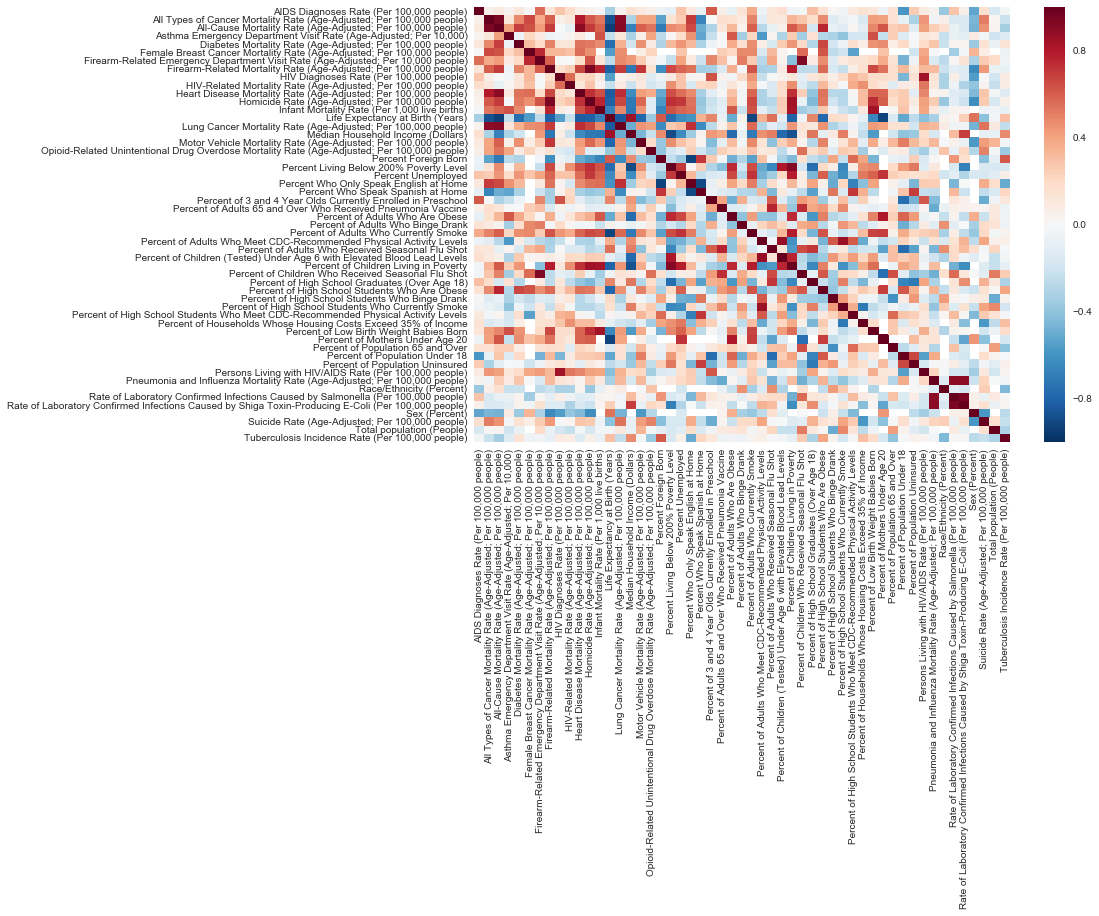

In [25]:
health_corr_mat = health_reshaped[health_reshaped['Rate of Laboratory Confirmed Infections Caused by Shiga Toxin-Producing E-Coli (Per 100,000 people)']<200].corr()
plt.figure(figsize=(12,8))
sns.heatmap(health_corr_mat)
plt.show()

Kendall's seems to be more robust to outliers.

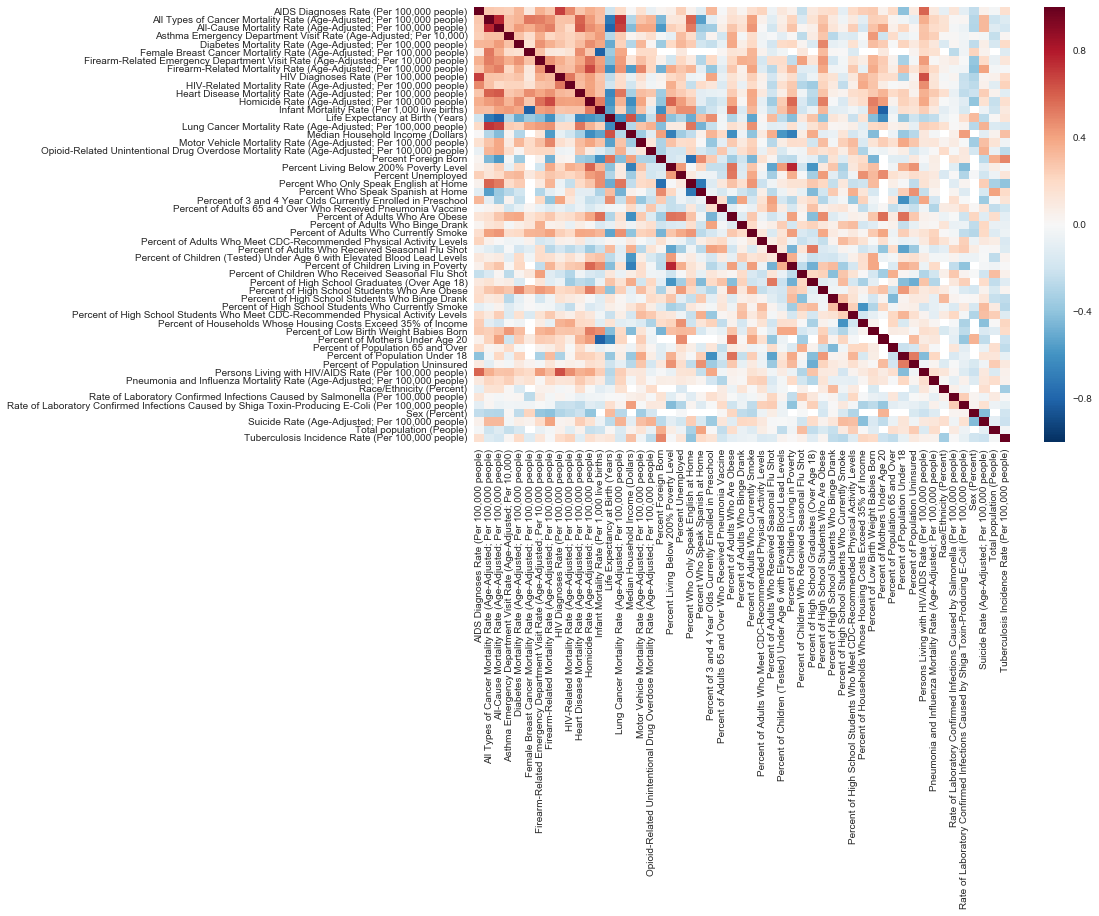

In [26]:
health_corr_mat = health_reshaped.corr(method='kendall')
plt.figure(figsize=(12,8))
sns.heatmap(health_corr_mat)
plt.show()

In [62]:
help(ax.yaxis.label.set_ha)

Help on method set_ha in module matplotlib.text:

set_ha(self, align) method of matplotlib.text.Text instance
    alias for set_horizontalalignment



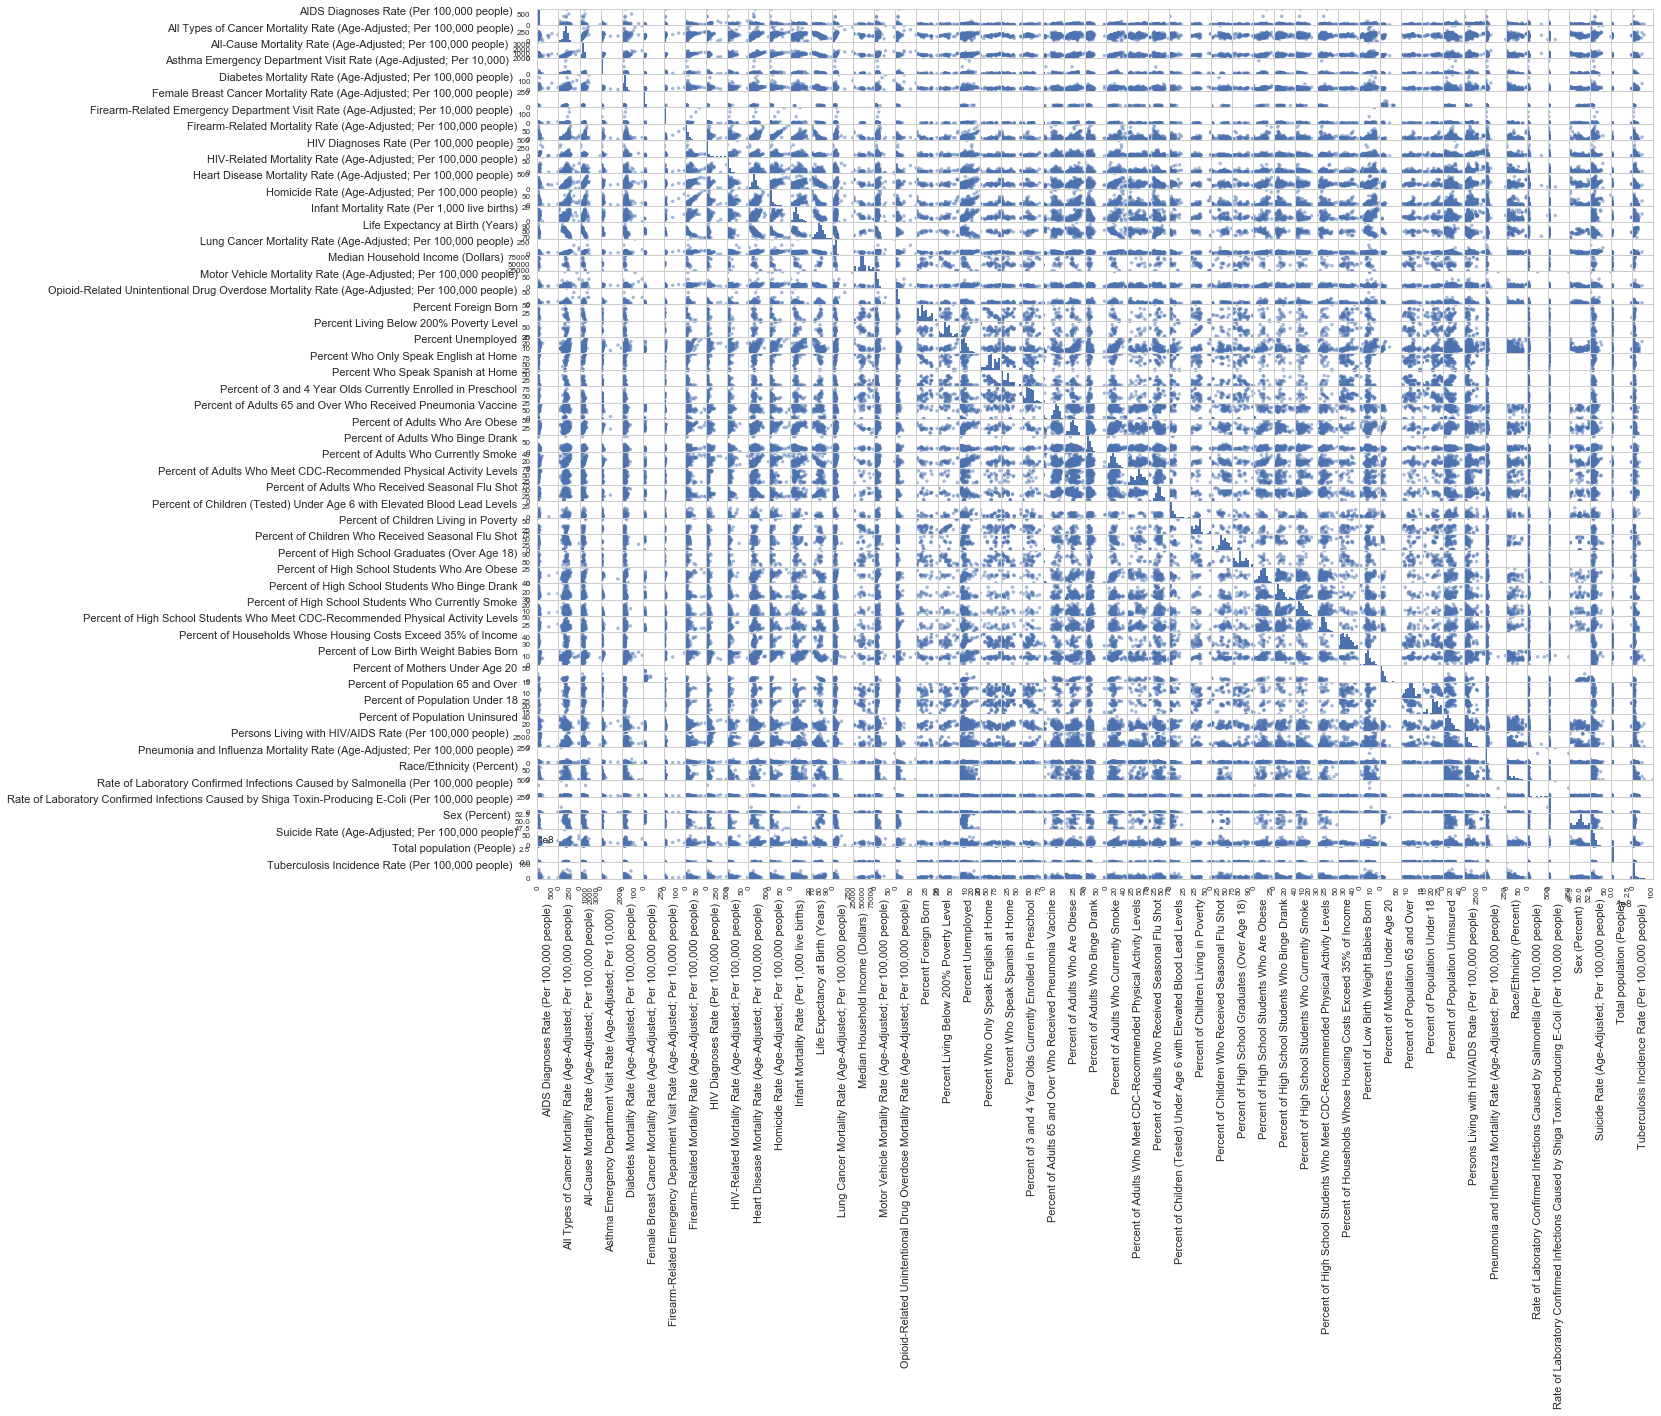

In [68]:
axs = pd.plotting.scatter_matrix(health_reshaped, figsize=(20,16))
n = 53
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.label.set_ha('right')

### Correlation Matrix Investigations

The goal's pretty simple: investigate any relationships with strong positive or negative correlations.

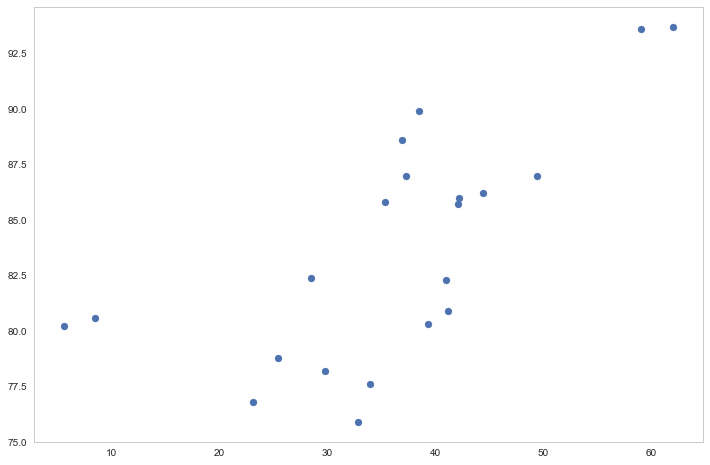

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(
    x='Percent of Adults Who Received Seasonal Flu Shot',
    y='Percent of High School Graduates (Over Age 18)',
    data=health_reshaped
)
plt.show()

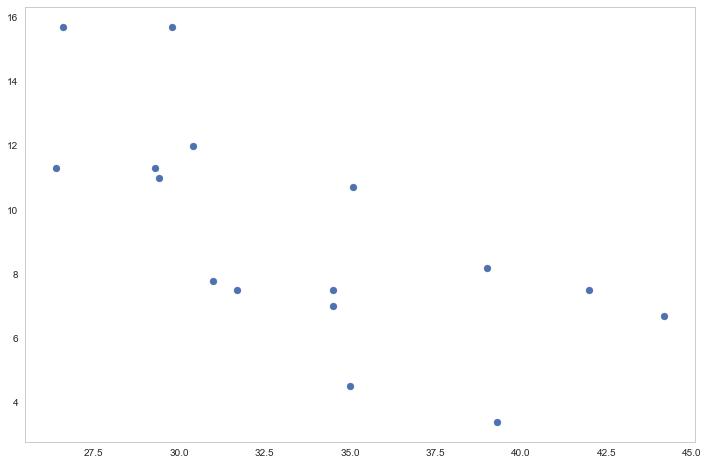

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(
    x='Percent of Households Whose Housing Costs Exceed 35% of Income',
    y='Percent of High School Students Who Currently Smoke',
    data=health_reshaped
)
plt.show()

### Chronic Disease

Let's examine the distributions of chronic diseases and how they interact with other variables.

In [38]:
health_reshaped.describe()

AIDS Diagnoses Rate (Per 100,000 people)  \
count                                527.000000   
mean                                  23.403321   
std                                   51.342062   
min                                    0.000000   
25%                                    7.100000   
50%                                   12.900000   
75%                                   24.500000   
max                                  736.600000   

       All Types of Cancer Mortality Rate (Age-Adjusted; Per 100,000 people)  \
count                                         687.000000                       
mean                                          154.158297                       
std                                            53.019138                       
min                                             0.000000                       
25%                                           122.100000                       
50%                                           155.600000                       
75%                                           184.450000                       
max                                           453.500000                       

       All-Cause Mortality Rate (Age-Adjusted; Per 100,000 people)  \
count                                         517.000000             
mean                                          690.400677             
std                                           262.317598             
min                                           109.400000             
25%                                           520.000000             
50%                                           670.500000             
75%                                           810.500000             
max                                          3594.600000             

       Asthma Emergency Department Visit Rate (Age-Adjusted; Per 10,000)  \
count                                         255.000000                   
mean                                           98.463922                   
std                                           179.942567                   
min                                             0.000000                   
25%                                            34.800000                   
50%                                            60.900000                   
75%                                           113.700000                   
max                                          2034.900000                   

       Diabetes Mortality Rate (Age-Adjusted; Per 100,000 people)  \
count                                         630.000000            
mean                                           24.538413            
std                                            14.504066            
min                                             0.000000            
25%                                            16.625000            
50%                                            21.900000            
75%                                            28.475000            
max                                           170.300000            

       Female Breast Cancer Mortality Rate (Age-Adjusted; Per 100,000 people)  \
count                                         393.000000                        
mean                                           19.951654                        
std                                            17.044399                        
min                                             0.000000                        
25%                                            12.600000                        
50%                                            19.800000                        
75%                                            24.400000                        
max                                           272.400000                        

       Firearm-Related Emergency Department Visit Rate (Age-Adjusted; Per 10,000 people)  \
count                                         194.000000          

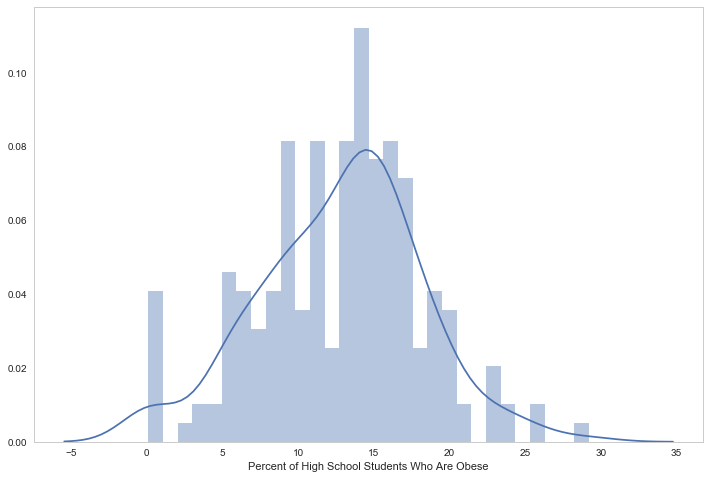

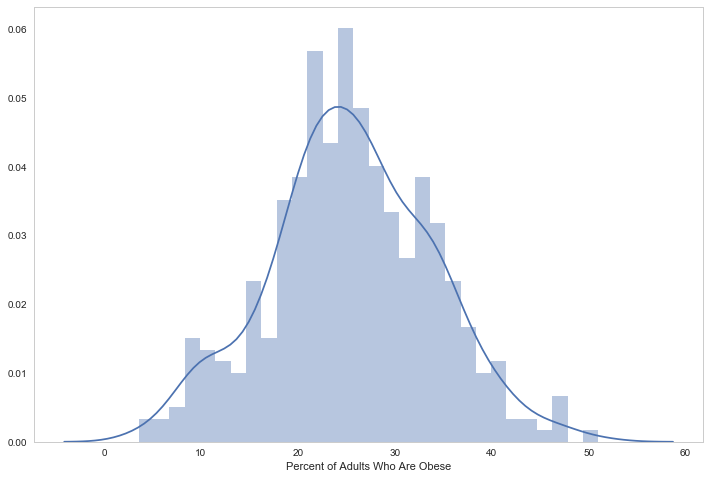

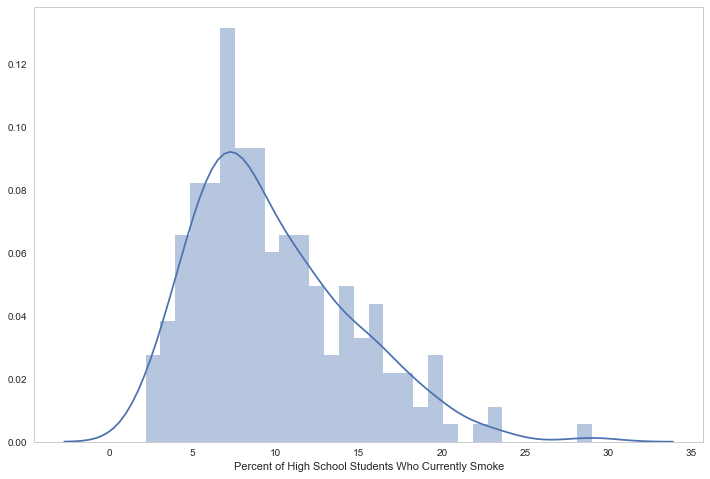

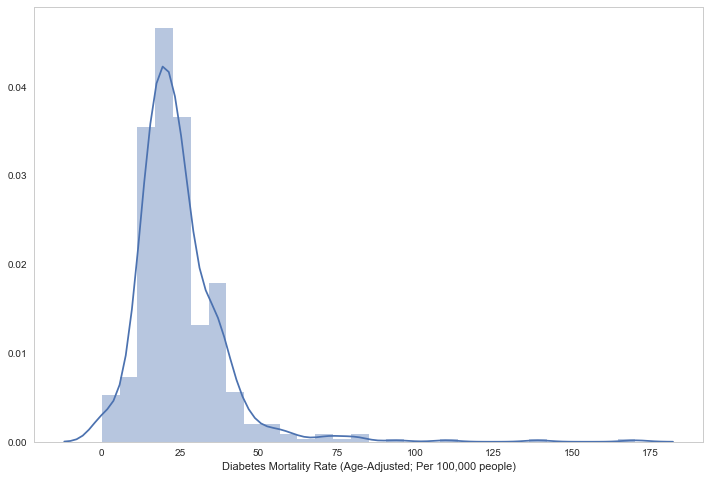

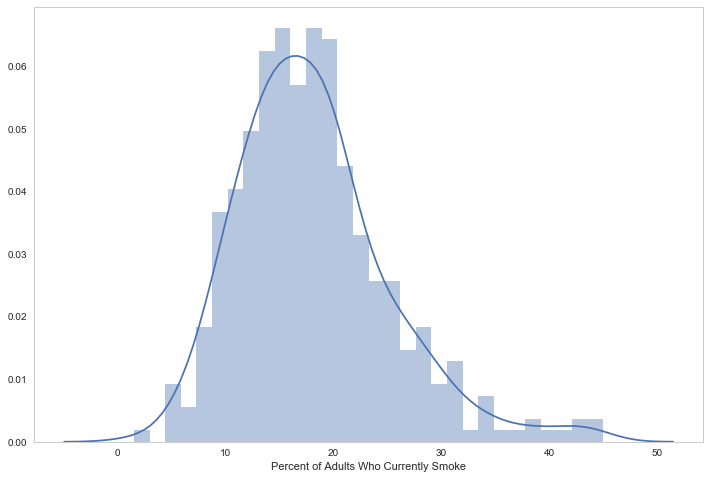

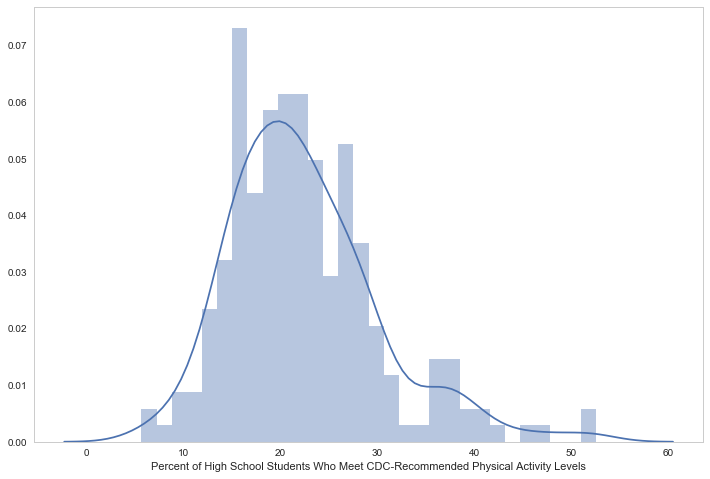

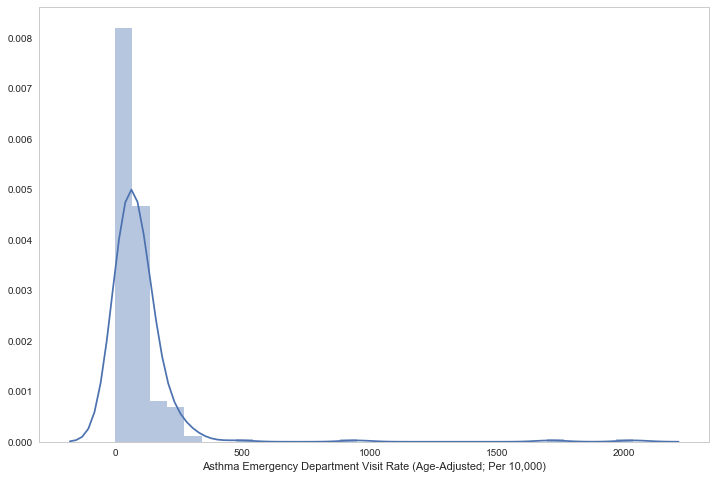

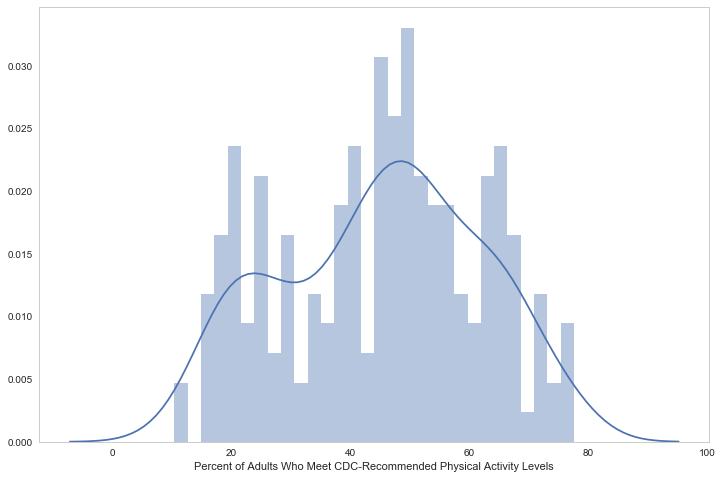

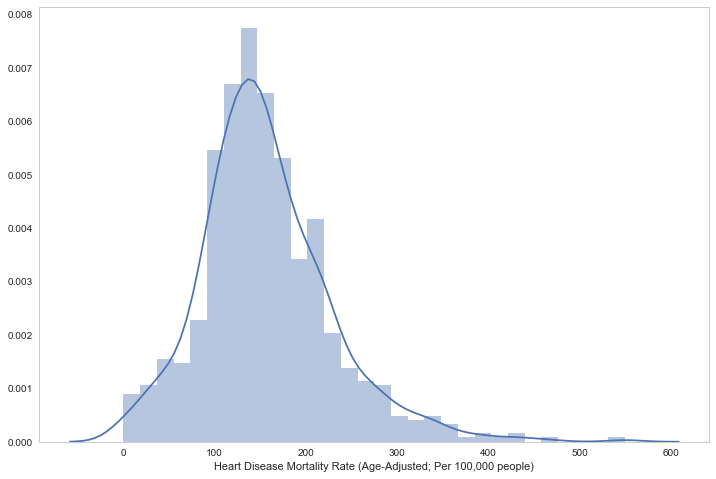

In [48]:
chronic_diseases = set(health_df[health_df['Indicator Category']=='Chronic Disease'].Indicator)

for chronic_disease in chronic_diseases:
    plt.figure(figsize=(12,8))
    sns.distplot(health_reshaped[chronic_disease].dropna(), bins=30)
    plt.show()

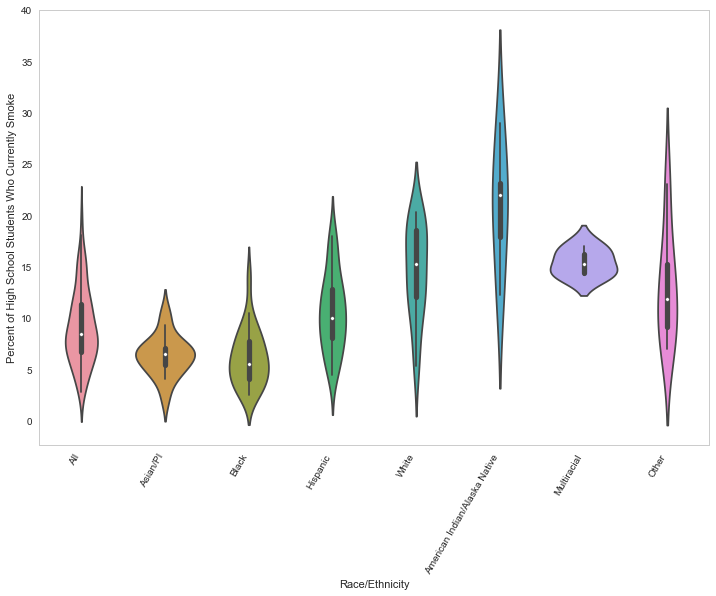

In [24]:
plt.figure(figsize=(12,8))
sns.violinplot(
    data=health_reshaped,
    x='Race/Ethnicity',
    y='Percent of High School Students Who Currently Smoke'
)
plt.xticks(rotation=60, ha='right')
plt.show()

### Behavioral/Substance Abuse

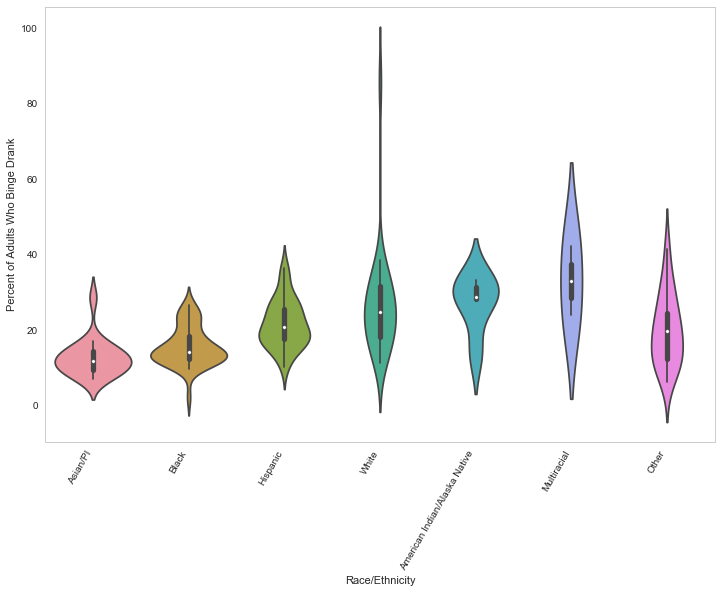

In [44]:
plt.figure(figsize=(12,8))
sns.violinplot(
    x='Race/Ethnicity',
    y='Percent of Adults Who Binge Drank',
    data=health_reshaped[health_reshaped['Race/Ethnicity']!='All'],
)
plt.xticks(rotation=60, ha='right')
plt.show()

### Life Expectancy/Death Rate

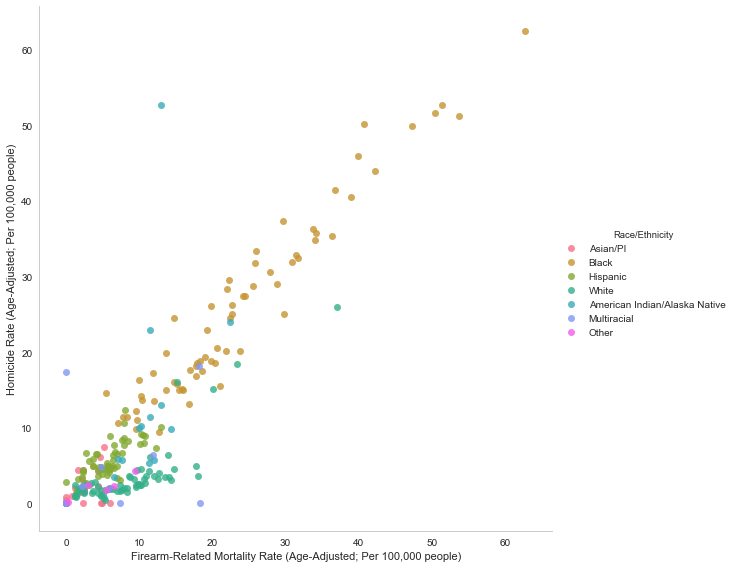

In [37]:
#plt.figure(figsize=(12,8))
sns.lmplot(
    x='Firearm-Related Mortality Rate (Age-Adjusted; Per 100,000 people)',
    y='Homicide Rate (Age-Adjusted; Per 100,000 people)',
    data=health_reshaped[health_reshaped['Race/Ethnicity']!='All'],
    hue='Race/Ethnicity',
    size=8,
    ci=None,
    fit_reg=False
)
plt.show()

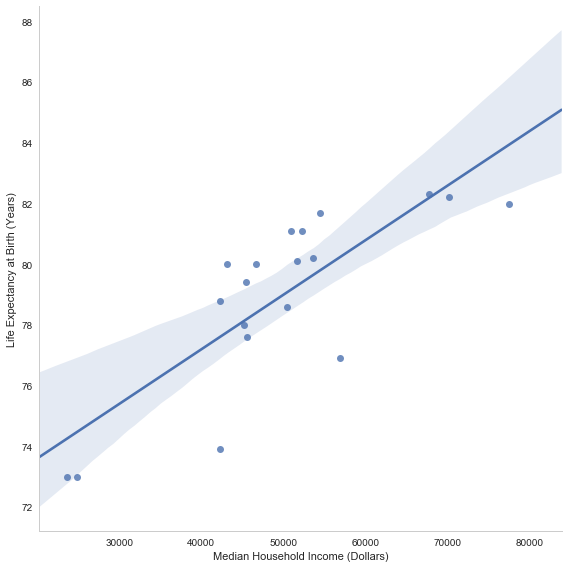

In [36]:
#plt.figure(figsize=(12,8))
sns.lmplot(
    x='Median Household Income (Dollars)',
    y='Life Expectancy at Birth (Years)',
    data=health_reshaped,
    size=8,
)
plt.show()

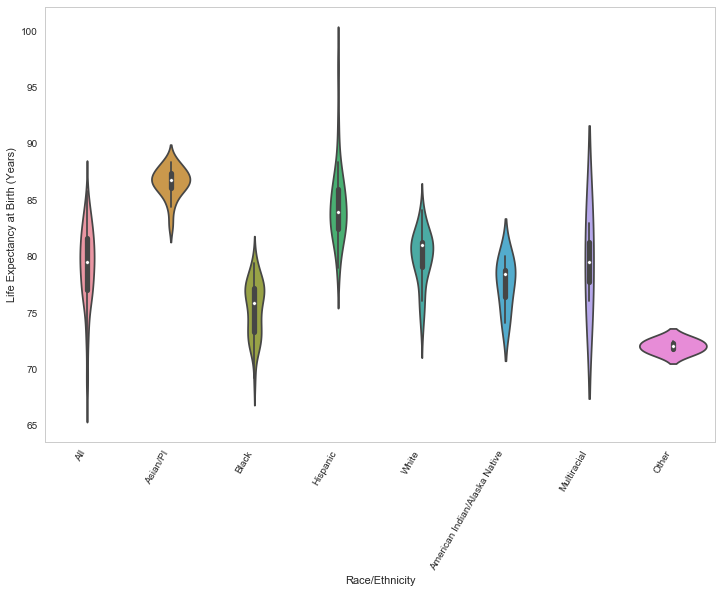

In [23]:
plt.figure(figsize=(12,8))
sns.violinplot(
    data=health_reshaped,
    x='Race/Ethnicity',
    y='Life Expectancy at Birth (Years)'
)
plt.xticks(rotation=60, ha='right')
plt.show()

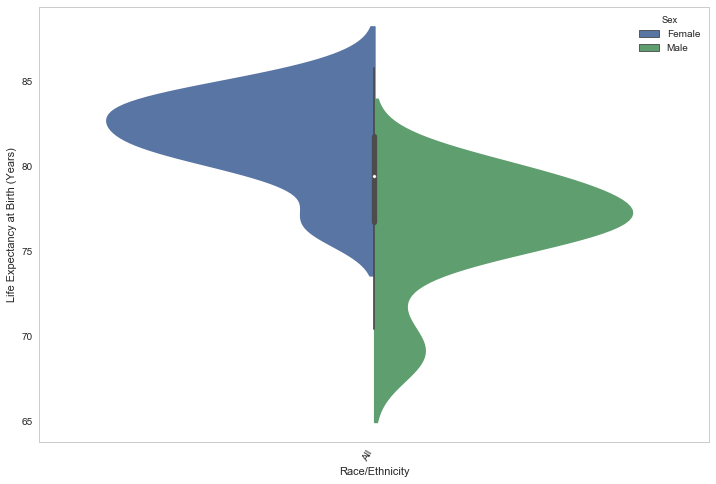

In [29]:
plt.figure(figsize=(12,8))
sns.violinplot(
    data=health_reshaped[(health_reshaped['Sex']!='Both') & (health_reshaped['Race/Ethnicity']=='All')],
    x='Race/Ethnicity',
    y='Life Expectancy at Birth (Years)',
    hue='Sex',
    split=True
)
plt.xticks(rotation=60, ha='right')
plt.show()

### 

## Feature Engineering

Need to figure out what you want to predict. Look at all features and decide what might be most useful to a hospital or healthcare provider. Then look at features and decide:

1. Which ones might be useful
2. Whether they require scaling
3. Transform necessary categorical variables

## Modeling

Use a variety of algorithms, pick the best one or two and tune those parameters.

## Plan

Now that we have a better idea of the overall data structure, we can better formulate a plan as to what to do with the data. We have reshaped it so that we can document interactions between variables. There are many avenues to explore in regards to visualizations, variable interactions, and modeling. What might be important to an insurance company or hospital looking at this data? There are both visualizations and models that they are probably interested in.

### Vizualiations

For visualizations, let's throw a few in here but also try a few out in Tableau. Tableau will be quicker and because we can just drag and drop. If we need to do any major reshaping, that can easily be done in Python before porting back into Tableau.

Let's create the visualizations we have in our list above, then dive into Tableau to look at what else can be made.

1. Plan which features you want to explore
  1. Can't do all 53, untenable
  2. Can do overview and automate certain parts to accomplish more
  3. Choose some that are interesting to you and some that may be of interest to organizations. Not carving out of marble. It's always possible to come back for more later
    1. Chronic Disease
    2. Infectious disease
    3. Behavioral health/substance abuse
    4. Life expectancy / death rate
2. Create visualizations in list
3. Create more in Tableau

### Models

For models, we need to think carefully about what insights might be important:
- Mortality rates?
- Cancer rates?
- Separate classifiers by gender and ethnicity?

Before we can create our models, however; we need to research what we can do with all the missing data points. Just about every row has missing data and I don't believe our algorithms can work with them in that form. Do we need imputation? Should we delete columns with mostly sparse data? If there are rows that are mostly complete, should we just use those? Let's take another look at the missing data now that the data has been reshaped. Then we'll research what can be done for the remaining data.

1. Visualize missing data with msno
2. Research missing workarounds: 
  1. Titanic
  2. Look for others
3. Decide whether we can continue with models or we need to just stick to visualizations
4. Choose appropriate algorithms for the data
5. Model a handful
6. Tune algorithms
7. Share insights
8. Move on

## 

## 

## 